<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE5-WEEK3/m05w03_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
#  đặt giá trị ngẫu nhiên cho hệ thống
# với các lần lặp là cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [ ]:
# chuyển dữ liệu sang bên GPU để thuận tiện cho việc tính toán dữ liệu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [ ]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [ ]:
x = dataset.drop('MPG', axis=1).values
y = dataset['MPG'].values

In [ ]:
# chia dữ liệu ra thành 3 phần cho quá trình test và quá trình kiểm tra
val_size = 0.2
test_size = 0.125
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle)

In [ ]:
normalizer = StandardScaler()
x_train = normalizer.fit_transform(x_train)
x_val = normalizer.transform(x_val)
x_test = normalizer.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# prompt: print shape của train, val, test

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: torch.Size([273, 9])
Shape of y_train: torch.Size([273])
Shape of x_val: torch.Size([79, 9])
Shape of y_val: torch.Size([79])
Shape of x_test: torch.Size([40, 9])
Shape of y_test: torch.Size([40])


In [ ]:
# xây dựng lớp dataloader
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
# tạo batchsize cho data
# hàm Dataloader này có mục đích
batch_size = 32
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

# dataloader dùng để lấy môt batch dữ liệu cùng một lúc, thuận tiện cho việc train
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# xây dựng một mạng multi layer perceptrons
class MLP(nn.Module): # kế thừa từ lớp Module
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)


  def forward(self, x):
    x = self.linear1(x)
    x = F.tanh(x)
    x = self.linear2(x)
    x = F.tanh(x)
    out = self.output(x)
    return out.squeeze(1)

In [ ]:
# xác định chiều đầu vào và đầu ra của kiến trúc
input_dims = x_train.shape[1]
hidden_dims = 64
output_dims = 1
#output = 1 là do đây không phải là mô hình phân loại mà là mô hình liên tục


In [ ]:
model = MLP(input_dims, hidden_dims, output_dims).to(device)

# khai báo hàm loss và opimizer
lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
#

In [ ]:
# xây dựng hàm số tính điểm loader
def r_squared(y_true, y_pred):
  # chuyển dữ liệu qua GPU
  y_true = torch.Tensor(y_true).to(device)
  y_pred = torch.Tensor(y_pred).to(device)
  y_mean = torch.mean(y_true)
  ss_tot = torch.sum((y_true - y_mean) ** 2)
  ss_res = torch.sum((y_true - y_pred) ** 2)
  r2 = 1 - (ss_res / ss_tot)
  return r2

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_r_squared = []
val_r_squared = []
for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_pred = []
  val_target = []
  val_pred = []

  # phần dùng để train
  model.train()
  for x_batch, y_batch in train_dataloader:
    x_batch = x_batch.to(device) # chuyển sang GPU
    y_batch = y_batch.to(device) # chuyển sang GPU
    optimizer.zero_grad()
    outputs = model(x_batch)
    train_pred += outputs.tolist()
    train_target += y_batch.tolist()
    loss = criterion(outputs, y_batch)
    # y_batch.unsqueeze(1) dùng để điều chỉnh shape của y khi tính loss
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss = train_loss / len(train_dataloader)
  train_losses.append(train_loss)
  train_r_squared.append(r_squared(y_true=train_target, y_pred=train_pred))

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for x_batch, y_batch in val_dataloader:
      x_batch = x_batch.to(device) # chuyển sang GPU
      y_batch = y_batch.to(device) # chuyển sang GPU
      outputs = model(x_batch)
      val_pred += outputs.tolist()
      val_target += y_batch.tolist()
      loss = criterion(outputs, y_batch)
      val_loss += loss.item()
    val_loss = val_loss / len(val_dataloader)
    val_losses.append(val_loss)
    val_r_squared.append(r_squared(y_true=val_target, y_pred=val_pred))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100, Train Loss: 241.3672, Val Loss: 16.7442
Epoch 2/100, Train Loss: 25.8016, Val Loss: 10.4082
Epoch 3/100, Train Loss: 17.0054, Val Loss: 8.8275
Epoch 4/100, Train Loss: 12.8983, Val Loss: 7.9893
Epoch 5/100, Train Loss: 12.0648, Val Loss: 7.3177
Epoch 6/100, Train Loss: 10.6116, Val Loss: 6.5591
Epoch 7/100, Train Loss: 9.5985, Val Loss: 6.7420
Epoch 8/100, Train Loss: 9.5454, Val Loss: 8.1855
Epoch 9/100, Train Loss: 9.6271, Val Loss: 11.1487
Epoch 10/100, Train Loss: 10.4211, Val Loss: 12.5893
Epoch 11/100, Train Loss: 10.5812, Val Loss: 6.0849
Epoch 12/100, Train Loss: 8.2037, Val Loss: 5.3742
Epoch 13/100, Train Loss: 8.7245, Val Loss: 6.7488
Epoch 14/100, Train Loss: 8.0676, Val Loss: 5.7307
Epoch 15/100, Train Loss: 7.9309, Val Loss: 6.7126
Epoch 16/100, Train Loss: 8.3085, Val Loss: 6.8000
Epoch 17/100, Train Loss: 7.8153, Val Loss: 6.3034
Epoch 18/100, Train Loss: 7.9920, Val Loss: 6.0946
Epoch 19/100, Train Loss: 8.0610, Val Loss: 5.7719
Epoch 20/100, Train Loss: 7

In [ ]:
model.eval()
with torch.no_grad():
  y_hat = model(x_test)
  r2_score = r_squared(y_true=y_test, y_pred=y_hat)
  print(f'R2 Score: {r2_score}')

R2 Score: 0.8968066573143005


In [ ]:
# list +  list
m = [[1,2,3]]
d = [[4,5,6]]
m+d

[[1, 2, 3], [4, 5, 6]]

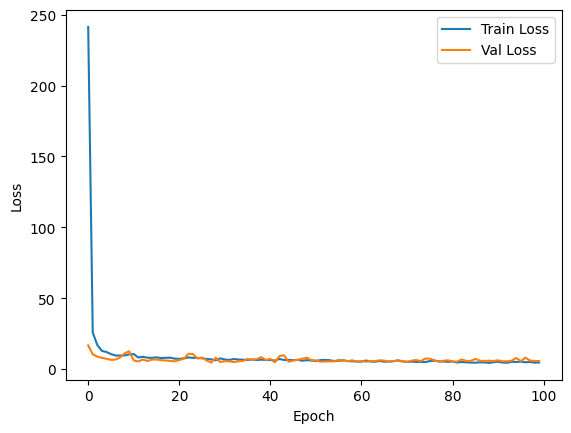

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

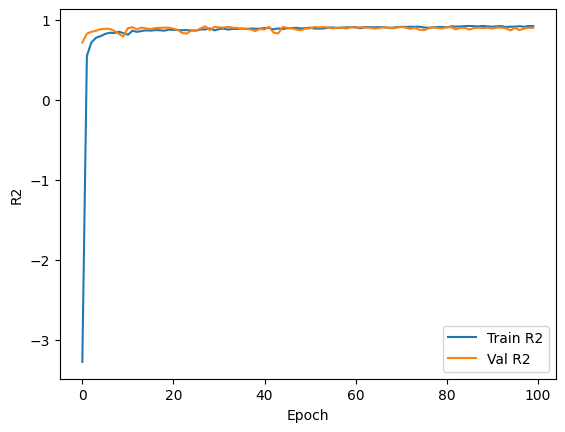

In [ ]:
plt.plot(train_r_squared, label='Train R2')
plt.plot(val_r_squared, label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

# Dành cho trắc nghiệm

### EX6

In [ ]:
x_1 = torch.tensor([5.1, 6.0, 5.7], dtype=torch.float32).reshape(-1,1)
y_1 = torch.tensor([0, 1, 0], dtype=torch.float32).reshape(-1,1)

In [ ]:
import torch
import torch.nn as nn

# Định nghĩa mô hình MLP
model = nn.Sequential(
    nn.Linear(1, 2),  # Hidden layer
    nn.ReLU(),        # Hàm kích hoạt
    nn.Linear(2, 1),  # Output layer
)

# Hàm khởi tạo trọng số
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        if m.in_features == 1 and m.out_features == 2:  # Hidden layer
            m.weight.data = torch.tensor([[0.5], [-0.5]])  # Trọng số hidden layer
            m.bias.data = torch.tensor([1.0, -1.0])        # Bias hidden layer
        elif m.in_features == 2 and m.out_features == 1:  # Output layer
            m.weight.data = torch.tensor([[0.3, -0.2]])    # Trọng số output layer
            m.bias.data = torch.tensor([0.5])              # Bias output layer

# Áp dụng khởi tạo trọng số
model.apply(initialize_weights)

# Kiểm tra trọng số sau khi khởi tạo
print("Trọng số Hidden layer:", model[0].weight)
print("Bias Hidden layer:", model[0].bias)
print("Trọng số Output layer:", model[2].weight)
print("Bias Output layer:", model[2].bias)

Trọng số Hidden layer: Parameter containing:
tensor([[ 0.5000],
        [-0.5000]], requires_grad=True)
Bias Hidden layer: Parameter containing:
tensor([ 1., -1.], requires_grad=True)
Trọng số Output layer: Parameter containing:
tensor([[ 0.3000, -0.2000]], requires_grad=True)
Bias Output layer: Parameter containing:
tensor([0.5000], requires_grad=True)


In [ ]:
# some params
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

In [ ]:
for i in range(len(x_1)):
    x = x_1[i]  # Đảm bảo x có kích thước (1, feature_size)
    y = y_1[i] # Thêm một chiều để y có kích thước tương thích
    print(f'x: {x}')
    print(f'y: {y}')

    # y_hat
    z= model(x)
    print(f'z: {z}')

    # loss
    loss = loss_fn(z, y)
    print(f'loss: {loss.item()}')

    # compute gradient
    optimizer.zero_grad()
    loss.backward()
    #print(f'(db, dw): ({model.bias.grad.data}, {model.weight.grad.data})')
    print("Trọng số Hidden layer:", model[0].weight)
    print("Bias Hidden layer:", model[0].bias)
    print("Trọng số Output layer:", model[2].weight)
    print("Bias Output layer:", model[2].bias)
    # update
    optimizer.step()

x: tensor([5.1000])
y: tensor([0.])
z: tensor([1.5650], grad_fn=<ViewBackward0>)
loss: 1.754866361618042
Trọng số Hidden layer: Parameter containing:
tensor([[ 0.5000],
        [-0.5000]], requires_grad=True)
Bias Hidden layer: Parameter containing:
tensor([ 1., -1.], requires_grad=True)
Trọng số Output layer: Parameter containing:
tensor([[ 0.3000, -0.2000]], requires_grad=True)
Bias Output layer: Parameter containing:
tensor([0.5000], requires_grad=True)
x: tensor([6.])
y: tensor([1.])
z: tensor([1.5531], grad_fn=<ViewBackward0>)
loss: 0.19194039702415466
Trọng số Hidden layer: Parameter containing:
tensor([[ 0.4873],
        [-0.5000]], requires_grad=True)
Bias Hidden layer: Parameter containing:
tensor([ 0.9975, -1.0000], requires_grad=True)
Trọng số Output layer: Parameter containing:
tensor([[ 0.2706, -0.2000]], requires_grad=True)
Bias Output layer: Parameter containing:
tensor([0.4917], requires_grad=True)
x: tensor([5.7000])
y: tensor([0.])
z: tensor([1.5457], grad_fn=<ViewBac

In [ ]:
x_test = torch.tensor([5.1], dtype=torch.float32)
z = model(x_test)
y_hat = torch.sigmoid(z)
print(f'y_hat: {y_hat}')

y_hat: tensor([0.7908], grad_fn=<SigmoidBackward0>)


### EX7

In [ ]:
x_2 = torch.tensor([50, 60, 70], dtype=torch.float32).reshape(-1,1)
y_2 = torch.tensor([100, 120, 140], dtype=torch.float32).reshape(-1,1)

In [ ]:
# some params
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

In [ ]:
import torch
import torch.nn as nn

# Định nghĩa mô hình MLP
model = nn.Sequential(
    nn.Linear(1, 2),  # Hidden layer
    nn.ReLU(),        # Hàm kích hoạt
    nn.Linear(2, 1),  # Output layer
)

# Hàm khởi tạo trọng số
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        if m.in_features == 1 and m.out_features == 2:  # Hidden layer
            m.weight.data = torch.tensor([[0.5], [-0.5]], dtype=torch.float)  # Trọng số hidden layer
            m.bias.data = torch.tensor([1.0, -1.0], dtype=torch.float)        # Bias hidden layer
        elif m.in_features == 2 and m.out_features == 1:  # Output layer
            m.weight.data = torch.tensor([[1.5, 2.0]], dtype=torch.float)    # Trọng số output layer
            m.bias.data = torch.tensor([0.0], dtype=torch.float)            # Bias output layer

# Áp dụng khởi tạo trọng số
model.apply(initialize_weights)

# Kiểm tra trọng số sau khi khởi tạo
print("Trọng số Hidden layer:", model[0].weight)
print("Bias Hidden layer:", model[0].bias)
print("Trọng số Output layer:", model[2].weight)
print("Bias Output layer:", model[2].bias)

Trọng số Hidden layer: Parameter containing:
tensor([[ 0.5000],
        [-0.5000]], requires_grad=True)
Bias Hidden layer: Parameter containing:
tensor([ 1., -1.], requires_grad=True)
Trọng số Output layer: Parameter containing:
tensor([[1.5000, 2.0000]], requires_grad=True)
Bias Output layer: Parameter containing:
tensor([0.], requires_grad=True)


In [ ]:
for i in range(len(x_2)):
    x = x_2[i]  # Đảm bảo x có kích thước (1, feature_size)
    y = y_2[i] # Thêm một chiều để y có kích thước tương thích
    print(f'x: {x}')
    print(f'y: {y}')

    # y_hat
    z= model(x)
    print(f'z: {z}')

    # loss
    loss = loss_fn(z, y)
    print(f'loss: {loss.item()}')

    # compute gradient
    optimizer.zero_grad()
    loss.backward()
    print(f'Gradient Hidden Layer (weight): {model[0].weight.grad}')
    print(f'Gradient Hidden Layer (bias): {model[0].bias.grad}')
    print(f'Gradient Output Layer (weight): {model[2].weight.grad}')
    print(f'Gradient Output Layer (bias): {model[2].bias.grad}')
    print()

    print("Trọng số Hidden layer:", model[0].weight)
    print("Bias Hidden layer:", model[0].bias)
    print("Trọng số Output layer:", model[2].weight)
    print("Bias Output layer:", model[2].bias)
    print()
    print()
    # update
    optimizer.step()

x: tensor([50.])
y: tensor([100.])
z: tensor([39.], grad_fn=<ViewBackward0>)
loss: 3721.0
Gradient Hidden Layer (weight): tensor([[-9150.],
        [    0.]])
Gradient Hidden Layer (bias): tensor([-183.,    0.])
Gradient Output Layer (weight): tensor([[-3172.,     0.]])
Gradient Output Layer (bias): tensor([-122.])

Trọng số Hidden layer: Parameter containing:
tensor([[ 0.5000],
        [-0.5000]], requires_grad=True)
Bias Hidden layer: Parameter containing:
tensor([ 1., -1.], requires_grad=True)
Trọng số Output layer: Parameter containing:
tensor([[1.5000, 2.0000]], requires_grad=True)
Bias Output layer: Parameter containing:
tensor([0.], requires_grad=True)


x: tensor([60.])
y: tensor([120.])
z: tensor([46.5000], grad_fn=<ViewBackward0>)
loss: 5402.25
Gradient Hidden Layer (weight): tensor([[-22380.],
        [     0.]])
Gradient Hidden Layer (bias): tensor([-403.5000,    0.0000])
Gradient Output Layer (weight): tensor([[-7729.,     0.]])
Gradient Output Layer (bias): tensor([-269.]

In [ ]:
x_test = torch.tensor([50], dtype=torch.float32)
y_hat = model(x_test)
print(f'y_hat: {y_hat}')

y_hat: tensor([39.], grad_fn=<ViewBackward0>)
